In [3]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
import datetime
from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy
from sklearn.decomposition import PCA


def generateNormalizationPlot(peak_areas,runOrder,batches,met_names,qc_inds,samp_inds,path):

    for x in range(peak_areas.shape[1]):
        fig,axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,1))
        axes[0].set_title("QC samples")
        axes[1].set_title("research samples")
        axes[0].scatter(runOrder[qc_inds],peak_areas[qc_inds,x],c=batches[qc_inds],s=1)
        axes[0].set_yticks([],[])
        #axes[0,0].set_ylabel(met_names[x],fontsize=6)
        
        axes[1].scatter(runOrder[samp_inds],peak_areas[samp_inds,x],c=batches[samp_inds],s=1)
        axes[1].set_yticks([],[])
        plt.tight_layout()
        plt.savefig(path + met_names[x] + ".png")
        plt.close()
        
def half_min_imputation(arr):

    #find the minimum non-zero value of each compound
    max_vals = [np.min([x for x in c if x > 1e-3]) for c in arr.transpose()]

    #impute values 
    data_imp = np.zeros(arr.shape)
    numImputted = 0
    numNon = 0

    for c in range(arr.shape[1]):
      for r in range(arr.shape[0]):
        #if not a missing value
        if arr[r,c] > 1e-3:
          data_imp[r,c] = arr[r,c]
          numNon += 1
        #if it is a missing value
        else:
          data_imp[r,c] = max_vals[c]/2
          numImputted += 1
    print(numImputted/(numImputted + numNon),"of values imputted")
    return data_imp

def normalizeData(peak_areas,batchInfo,qc_inds):
    reg = RandomForestRegressor(n_jobs=10)
    X = np.array(batchInfo[qc_inds])
    y = peak_areas[qc_inds] - np.mean(peak_areas[qc_inds],axis=0)
    reg.fit(X,y)
    preds = reg.predict(batchInfo)
    return peak_areas - preds

In [11]:
ship1Dir = "Y:/LLFS/data_analysis/polars/shipment1_analysis/integration/negative/"
ship2Dir = "Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/negative_knowns/skyline_documents/"
experimentParametersFn = "Y:/LLFS/data_analysis/sample_metadata/LLFS_Experiment_parameters_Shipment1and2.csv"
numQC = 9

In [13]:
metadata = pd.read_csv(experimentParametersFn)
metadata

,Batch #,Batch,Metabolomics identifier,Shipment
0,1,V,10014843_1,1
1,1,V,10014843_2,1
2,6,Q,10016673_1,1
3,6,Q,10016673_2,1
4,2,U,10041309_1,1
...,...,...,...,...
4000,43,AQ,49975486_1,2
4001,43,AQ,49975486_2,2
4002,12,F,49989098_1,1
4003,12,F,49989098_2,1


In [15]:
batches = [x for x in list(set(metadata["Batch"].values)) if x != "AR"]
batches.sort()
batches

['A',
 'AA',
 'AB',
 'AC',
 'AD',
 'AE',
 'AF',
 'AG',
 'AH',
 'AI',
 'AJ',
 'AK',
 'AL',
 'AM',
 'AN',
 'AO',
 'AP',
 'AQ',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [17]:
metadata = metadata[metadata["Batch"].isin(batches)]
metadata

,Batch #,Batch,Metabolomics identifier,Shipment
0,1,V,10014843_1,1
1,1,V,10014843_2,1
2,6,Q,10016673_1,1
3,6,Q,10016673_2,1
4,2,U,10041309_1,1
...,...,...,...,...
4000,43,AQ,49975486_1,2
4001,43,AQ,49975486_2,2
4002,12,F,49989098_1,1
4003,12,F,49989098_2,1


In [19]:
qc_df = {}
for batch in batches:
    batchNum = metadata[metadata["Batch"] == batch]["Batch #"].values[0]
    tmpNumQC = numQC
    if batch == "AP":
        tmpNumQC = 10
    if batch == "AR":
        tmpNumQC = 7
    #elif batch == "V":
    #    tmpNumQC = 8
    #else:
    #    tmpNumQC = numQC
    for qc in range(1,tmpNumQC+1):
        if qc < 10:
            if batch not in  ["A","B","C","D"]:
                qc_df[len(qc_df)] = {"Batch":batch,"Batch #":batchNum,"Metabolomics identifier":"QC_Splash_0" + str(qc)}
            else:
                qc_df[len(qc_df)] = {"Batch":batch,"Batch #":batchNum,"Metabolomics identifier":"QC_0" + str(qc)}
        else:
            if batch not in  ["A","B","C","D"]:
                qc_df[len(qc_df)] = {"Batch":batch,"Batch #":batchNum,"Metabolomics identifier":"QC_Splash_" + str(qc)}
            else:
                qc_df[len(qc_df)] = {"Batch":batch,"Batch #":batchNum,"Metabolomics identifier":"QC_" + str(qc)}
qc_df = pd.DataFrame.from_dict(qc_df,orient="index")
metadata = pd.concat((metadata,qc_df),axis=0,ignore_index=True)
metadata

,Batch #,Batch,Metabolomics identifier,Shipment
0,1,V,10014843_1,1.0
1,1,V,10014843_2,1.0
2,6,Q,10016673_1,1.0
3,6,Q,10016673_2,1.0
4,2,U,10041309_1,1.0
...,...,...,...,...
4320,26,Z,QC_Splash_05,NaN
4321,26,Z,QC_Splash_06,NaN
4322,26,Z,QC_Splash_07,NaN
4323,26,Z,QC_Splash_08,NaN


In [21]:
batchMapper = {batch:"" for batch in batches}
for batch in batches:
    for datadir in [ship1Dir,ship2Dir]:
        folders = os.listdir(datadir)
        for fold in folders:
            if "Batch" + batch in fold[-1*len("Batch" + batch):] or "Batch" + batch + "_" in fold and "2ndPlate" not in fold or "Batch" + batch + "-" in fold :
                batchMapper[batch] = datadir + fold

In [23]:
batchMapper

{'A': 'Y:/LLFS/data_analysis/polars/shipment1_analysis/integration/negative/BatchA',
 'AA': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/negative_knowns/skyline_documents/20220926_LLFS_nP_BatchAA',
 'AB': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/negative_knowns/skyline_documents/20220928_LLFS_nP_BatchAB',
 'AC': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/negative_knowns/skyline_documents/20220930_LLFS_nP_BatchAC',
 'AD': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/negative_knowns/skyline_documents/20221003_LLFS_nP_BatchAD',
 'AE': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/negative_knowns/skyline_documents/20221006_LLFS_nP_BatchAE',
 'AF': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/negative_knowns/skyline_documents/20221009_LLFS_nP_BatchAF',
 'AG': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/negative_knowns/skyline_documents/20221011_LLFS_nP_BatchAG',
 'AH': 'Y:/L

In [25]:
mergedDf = pd.DataFrame()
goodInds = []
filenames = ["" for _ in range(len(metadata))]
times = [datetime.datetime(1,1,1,1,1) for _ in filenames]
accounted = [False for _ in filenames]
for batch in batches:
        filt = metadata[metadata["Batch"] == batch]
        try: peak_areas = pd.read_csv(batchMapper[batch] + "/peak_areas_profile.csv",index_col=0)
        except: peak_areas = pd.read_csv(batchMapper[batch] + "/peak_areas.csv",index_col=0)
        
        if len(mergedDf) > 0:
            goodInds = list(set(peak_areas.index.values).intersection(set(mergedDf.index.values)))
            peak_areas = peak_areas.loc[goodInds,:]
            mergedDf = mergedDf.loc[goodInds,:]
        
        metInfo = peak_areas[peak_areas.columns.values[:3]]
        peak_areas = peak_areas[peak_areas.columns.values[3:]]
        file_times = pd.read_csv(batchMapper[batch] + "/aq_time_report.csv",index_col=0)
        for index,row in file_times.iterrows():
            tmp = row["Acquired Time"]
            month = int(tmp.split()[0].split("/")[0])
            day = int(tmp.split()[0].split("/")[1])
            year = int(tmp.split()[0].split("/")[2])
            hour = int(tmp.split()[1].split(":")[0])
            minute = int(tmp.split()[1].split(":")[1])
            if "PM" in tmp and hour != 12:
                hour += 12
            elif "AM" in tmp and hour == 12:
                hour -= 12
            file_times.at[index,"Acquired Time"] = datetime.datetime(year,month,day,hour,minute)
        files = [x.replace(" Area","") for x in peak_areas.columns.values]
        for index,row in filt.iterrows():
            matches = [x for x in files if row["Metabolomics identifier"] in x and "terative" not in x]
            if len(matches) > 0:
                matches.sort(key = lambda x: file_times.at[x+".d","Acquired Time"],reverse=True)
                t = file_times.at[matches[0] + ".d","Acquired Time"]
                #print([file_times.at[x + ".d","Acquired Time"] for x in matches])
                if t > times[index]:
                    times[index] = t
                    filenames[index] = matches[0]
                    accounted[index] = True

        mergedDf = pd.concat((mergedDf,peak_areas),axis=1,ignore_index=False)

times = [x.isoformat() for x in times]
metadata["filename polar pos"] = filenames
metadata["Acq times for polar pos"] = times
metadata["found matching filename polar pos"] = accounted
metadata["peak area sample name"] = ["Batch" + str(batch) + "_" + id for batch,id in zip(metadata["Batch #"],metadata["Metabolomics identifier"])]

In [26]:
filenames = list(metadata["filename polar pos"].values)
print(len(filenames))
goodCols = [f + " Area" for f in filenames if "Blank" not in f and f != ""]
filenames = [x.replace(" Area","") for x in goodCols]
print(len(filenames))
mergedDf = mergedDf[goodCols]
mergedDf = mergedDf.rename(mapper={c:c.replace(" Area","") for c in mergedDf.columns.values},axis=1)
mapper2 = {old:new for old,new in zip(metadata["filename polar pos"], metadata["peak area sample name"])}
mergedDf = mergedDf.rename(mapper=mapper2,axis=1)
filenames = [mapper2[x] for x in filenames]
metInfo.to_csv("metabolite_info_polar_neg.csv")
mergedDf.to_csv("merged_peak_areas_polar_neg.csv")
metadata["Acq times for polar pos"] = [datetime.datetime.fromisoformat(x) for x in metadata["Acq times for polar pos"].values]
metadata = metadata.sort_values(by = "Acq times for polar pos",ascending=True)
batchInfoDf = metadata.loc[metadata.index.values,["Acq times for polar pos","peak area sample name","Batch #"]]
batchInfoDf = batchInfoDf.rename(mapper={"Batch #":"batch"},axis=1)
batchInfoDf = batchInfoDf.set_index("peak area sample name")
batchInfoDf["order"] = list(range(1,len(batchInfoDf)+1))
batchInfoDf["sample batch order"] = list(range(1,len(batchInfoDf)+1))
batchInfoDf = batchInfoDf.loc[filenames,:]

for batch in list(set(batchInfoDf["batch"])):
    filt = batchInfoDf[batchInfoDf["batch"] == batch]
    filt = filt.sort_values(by="order",ascending=True)
    for index,i in zip(filt.index.values,range(1,len(filt)+1)):
        batchInfoDf.at[index,"sample batch order"] = i

batchInfoDf = batchInfoDf[["Acq times for polar pos","batch","sample batch order"]]
batchInfoDf = batchInfoDf.rename(mapper={"sample batch order":"order"},axis=1)        
batchInfoDf.to_csv("batchInfo_polar_neg.csv")

4325
4325


In [27]:
metadata

,Batch #,Batch,Metabolomics identifier,Shipment,filename polar pos,Acq times for polar pos,found matching filename polar pos,peak area sample name
3937,11,A,QC_01,NaN,BatchA_nP_QC_01,2021-04-12 09:23:00,True,Batch11_QC_01
1672,11,A,27754655_1,1.0,BatchA_nP_27754655_1,2021-04-12 09:46:00,True,Batch11_27754655_1
1949,11,A,29898244_1,1.0,BatchA_nP_29898244_1,2021-04-12 10:09:00,True,Batch11_29898244_1
860,11,A,21170212_1,1.0,BatchA_nP_21170212_1,2021-04-12 10:32:00,True,Batch11_21170212_1
1052,11,A,22647044_1,1.0,BatchA_nP_22647044_1,2021-04-12 10:55:00,True,Batch11_22647044_1
...,...,...,...,...,...,...,...,...
197,23,W,12150199_1,2.0,BatchW_nP_12150199_1,2022-12-01 21:03:00,True,Batch23_12150199_1
590,23,W,17564502_1,2.0,BatchW_nP_17564502_1,2022-12-01 21:26:00,True,Batch23_17564502_1
154,23,W,11672128_2,2.0,BatchW_nP_11672128_2,2022-12-01 21:48:00,True,Batch23_11672128_2
194,23,W,12100624_2,2.0,BatchW_nP_12100624_2,2022-12-01 22:11:00,True,Batch23_12100624_2


In [31]:
metadata.to_csv("metadata_outut_polar_neg.csv",index=False)

In [115]:
metadata[metadata["found matching filename polar pos"] == False].to_csv("missing.csv")

In [116]:
metadata[metadata["found matching filename polar pos"] == False]

,Batch #,Batch,Metabolomics identifier,Shipment,filename polar pos,Acq times for polar pos,found matching filename polar pos,peak area sample name


In [117]:
mergedDf

,Batch1_10014843_1,Batch1_10014843_2,Batch6_10016673_1,Batch6_10016673_2,Batch2_10041309_1,Batch2_10041309_2,Batch5_10094670_1,Batch5_10111300_1,Batch5_10187532_1,Batch1_10189066_1,...,Batch25_QC_Splash_09,Batch26_QC_Splash_01,Batch26_QC_Splash_02,Batch26_QC_Splash_03,Batch26_QC_Splash_04,Batch26_QC_Splash_05,Batch26_QC_Splash_06,Batch26_QC_Splash_07,Batch26_QC_Splash_08,Batch26_QC_Splash_09
Molecule Name,,,,,,,,,,,,,,,,,,,,,
TREHALOSE,57912,40926,9582,7994,101613,646059,8685,504121,29891,87729,...,205583,223537,242232,221402,210717,240407,231690,228103,228099,254771
INOSINE,59244412,629437,51065568,753821,59027972,312033,56321664,50988492,57168608,40517004,...,332190,338017,341019,331830,365798,360822,343604,334216,359451,346989
3 2 6 Dioxocyclohexyl propanenitrile,4047363,1714914,10059745,7554692,19066464,9586225,828911,825644,758977,1340994,...,1230468,598130,558864,582708,566121,603568,632063,594058,631163,617168
CITRULLINE,2824883,2937348,2768320,3401648,2796071,3889496,2962972,2550231,2945375,3471575,...,1495256,2046765,2057071,2125347,1992914,2145869,2072274,2232562,2256460,2348643
Indolelactic acid,9594812,4724450,5496300,10578284,4432200,4475188,3587475,9414382,2834850,5030944,...,1205890,1311044,1149590,1114354,1100193,1116881,1107366,1116888,1138681,1101595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U13C-U15N-Alanine,764822,696782,801038,698001,707042,673024,678071,649792,667519,704457,...,313927,293228,317454,328449,318948,347688,332841,337739,316282,343968
7-Hydroxy-3-Methylflavone,70023,59392,306534,26393,57552,125759,75445,84542,87072,42371,...,100353,89830,108297,96184,111463,108622,106216,95213,100039,107821
U13C-U15N-Proline,1178959,1175190,1414690,1365939,1243013,1224166,1718611,1643827,1716845,1220236,...,903039,765570,703838,704724,733567,695888,683410,749732,726493,738716


In [118]:
batchInfoDf

,Acq times for polar pos,batch,order
peak area sample name,,,
Batch1_10014843_1,2021-06-18 14:12:00,1,18
Batch1_10014843_2,2021-06-18 16:52:00,1,25
Batch6_10016673_1,2021-05-25 23:10:00,6,99
Batch6_10016673_2,2021-05-25 10:15:00,6,65
Batch2_10041309_1,2021-06-15 23:14:00,2,89
...,...,...,...
Batch26_QC_Splash_05,2022-09-21 05:58:00,26,53
Batch26_QC_Splash_06,2022-09-21 10:55:00,26,66
Batch26_QC_Splash_07,2022-09-21 15:51:00,26,79


In [119]:
metadata

,Batch #,Batch,Metabolomics identifier,Shipment,filename polar pos,Acq times for polar pos,found matching filename polar pos,peak area sample name
3937,11,A,QC_01,NaN,BatchA_nP_QC_01,2021-04-12 09:23:00,True,Batch11_QC_01
1672,11,A,27754655_1,1.0,BatchA_nP_27754655_1,2021-04-12 09:46:00,True,Batch11_27754655_1
1949,11,A,29898244_1,1.0,BatchA_nP_29898244_1,2021-04-12 10:09:00,True,Batch11_29898244_1
860,11,A,21170212_1,1.0,BatchA_nP_21170212_1,2021-04-12 10:32:00,True,Batch11_21170212_1
1052,11,A,22647044_1,1.0,BatchA_nP_22647044_1,2021-04-12 10:55:00,True,Batch11_22647044_1
...,...,...,...,...,...,...,...,...
197,23,W,12150199_1,2.0,BatchW_nP_12150199_1,2022-12-01 21:03:00,True,Batch23_12150199_1
590,23,W,17564502_1,2.0,BatchW_nP_17564502_1,2022-12-01 21:26:00,True,Batch23_17564502_1
154,23,W,11672128_2,2.0,BatchW_nP_11672128_2,2022-12-01 21:48:00,True,Batch23_11672128_2
194,23,W,12100624_2,2.0,BatchW_nP_12100624_2,2022-12-01 22:11:00,True,Batch23_12100624_2


In [120]:
peak_areas_imputted = deepcopy(mergedDf)
peak_areas_imputted[peak_areas_imputted.columns] = half_min_imputation(peak_areas_imputted.values.transpose()).transpose()

4.2038885969521805e-06 of values imputted


In [121]:
batchInfoDf = batchInfoDf.sort_values(by=["batch","order"],ascending=True)
runOrder = np.array(list(range(len(batchInfoDf))))
qc_inds = [x for x in range(len(batchInfoDf)) if "QC" in batchInfoDf.index.values[x]]
samp_inds = [x for x in range(len(batchInfoDf)) if x not in qc_inds]
batch_info = batchInfoDf[["batch","order"]].to_numpy()

In [122]:
#ensure order of peak areas and batch info is the same
peak_areas = peak_areas_imputted[batchInfoDf.index.values]
peak_areas_mat = np.log2(peak_areas.to_numpy()).transpose()

Text(0.5, 1.0, 'Before Normalization')

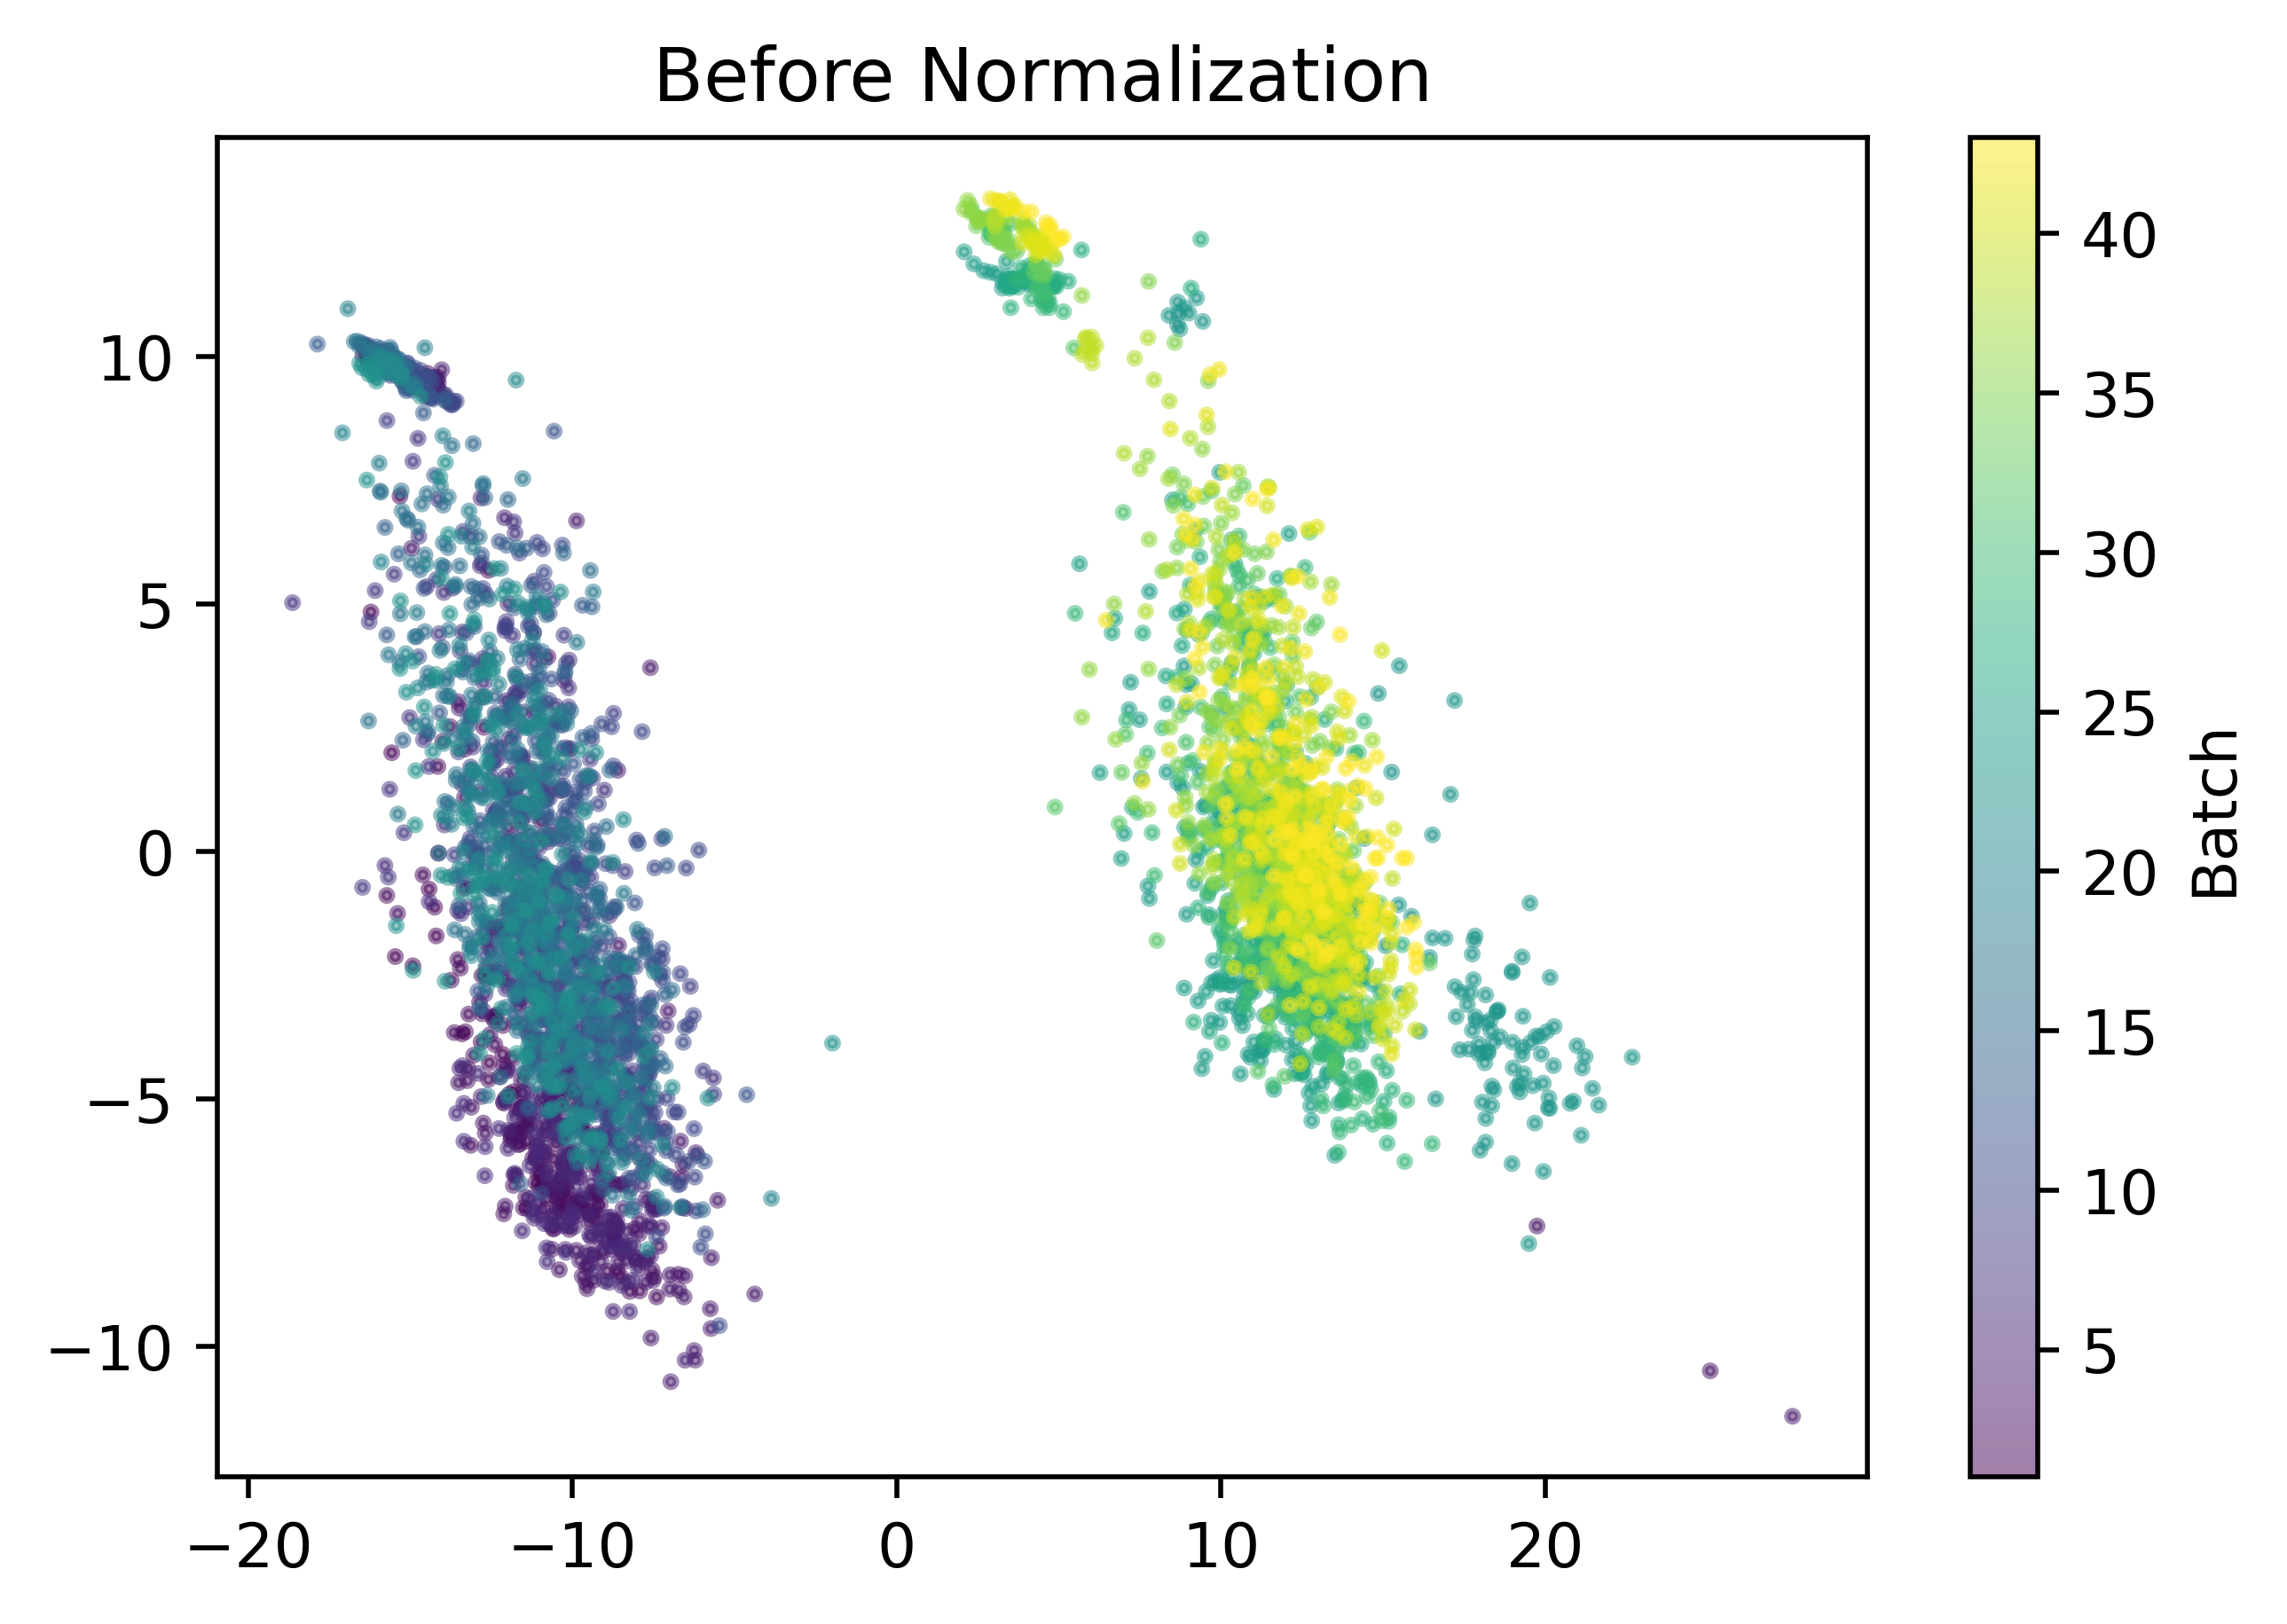

In [123]:
#do pca again
pca = PCA(n_components=2)
pca.fit(peak_areas_mat)
loads = pca.transform(peak_areas_mat)

#plot unnormalized PCA
plt.figure()
plt.scatter(loads[:,0],loads[:,1],c=batch_info[:,0],s=3,alpha=.5)
plt.colorbar(label="Batch")
plt.title("Before Normalization")

In [77]:
os.mkdir("unnormalized_peak_area_plots_polar_neg")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'unnormalized_peak_area_plots_polar_neg'

In [124]:
generateNormalizationPlot(peak_areas_mat,runOrder,batch_info[:,0],peak_areas.index.values,qc_inds,samp_inds,"unnormalized_peak_area_plots_polar_neg/")

In [125]:
peak_areas_norm = normalizeData(peak_areas_mat,batch_info,qc_inds)

Text(0.5, 1.0, 'After Normalization')

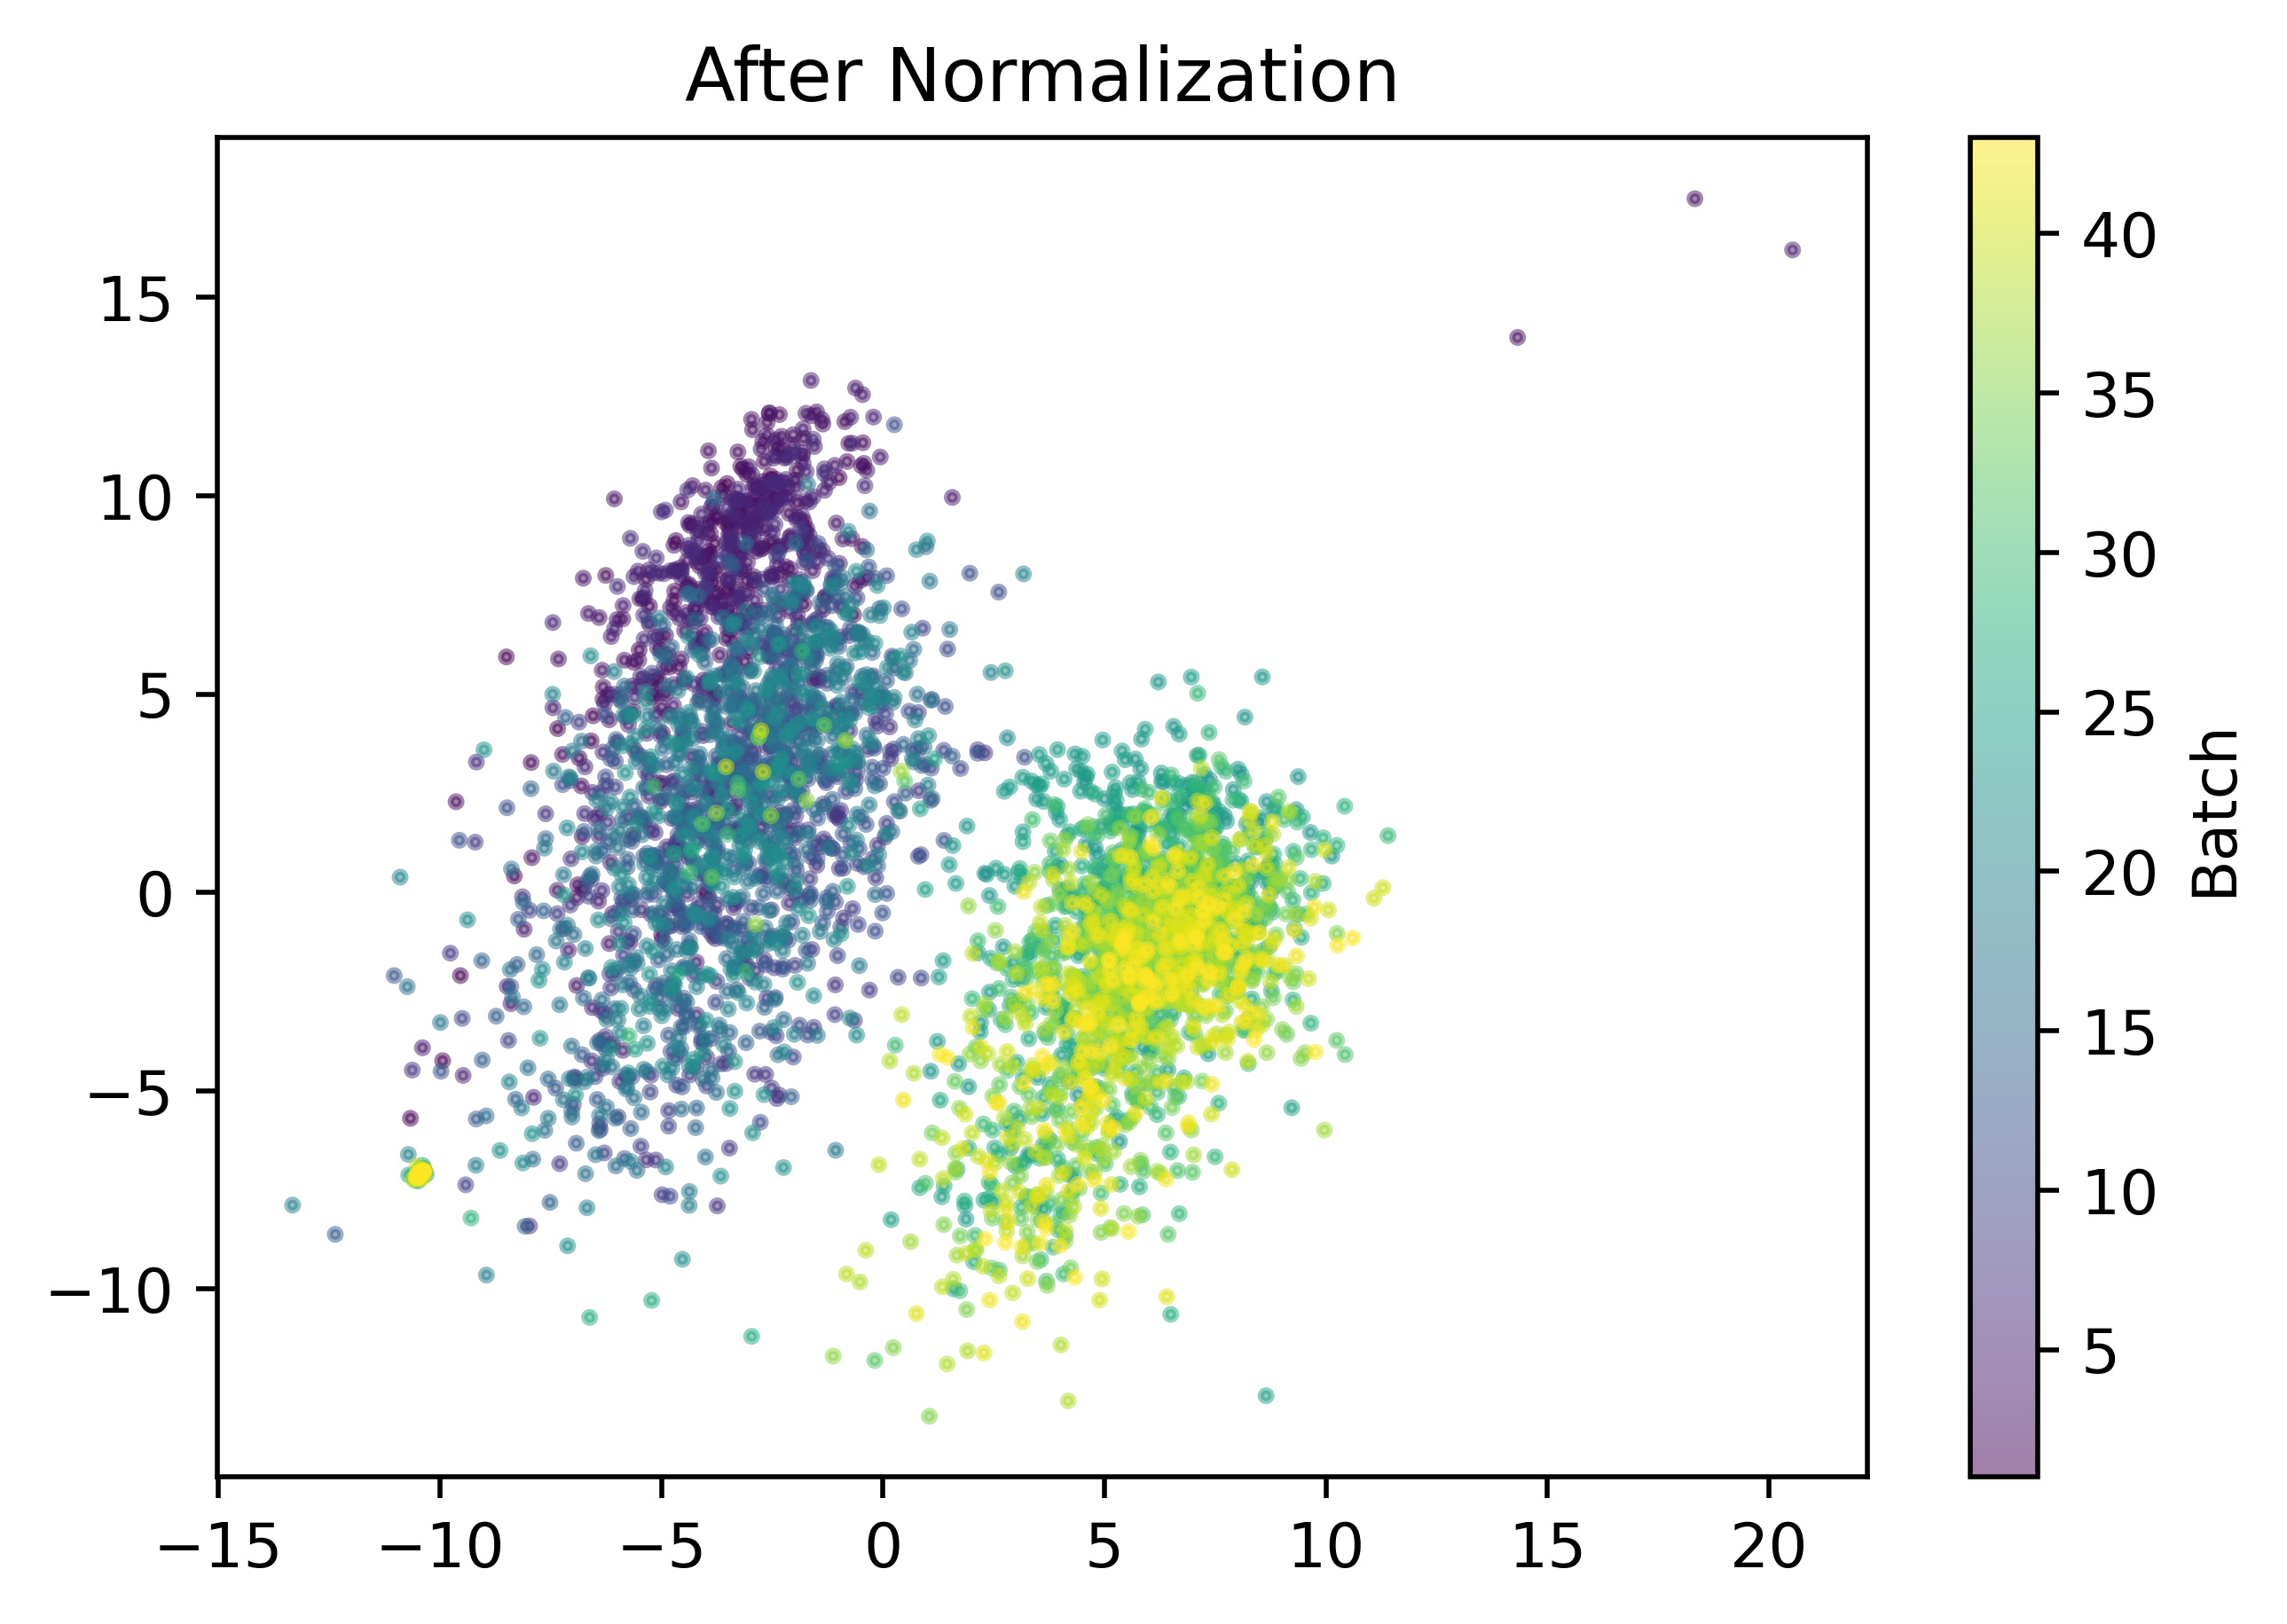

In [126]:
#do pca again
pca = PCA(n_components=2)
pca.fit(peak_areas_norm)
loads = pca.transform(peak_areas_norm)

#plot normalized PCA
plt.figure()
plt.scatter(loads[:,0],loads[:,1],c=batch_info[:,0],s=3,alpha=.5)
plt.colorbar(label="Batch")
plt.title("After Normalization")

In [127]:
peak_areas_norm = pd.DataFrame(np.power(2,peak_areas_norm).transpose(),index=peak_areas_imputted.index.values,columns=batchInfoDf.index.values)
peak_areas_norm

,Batch1_QC_Splash_01,Batch1_18270389_2,Batch1_13135943_1,Batch1_10800001_1,Batch1_13135943_2,Batch1_12397428_1,Batch1_10457357_1,Batch1_12552874_1,Batch1_12406146_1,Batch1_14179683_1,...,Batch43_QC_Splash_08,Batch43_47234570_1,Batch43_22592403_1,Batch43_21224361_2,Batch43_41519985_1,Batch43_48823298_2,Batch43_20214140_1,Batch43_41550303_1,Batch43_45611266_1,Batch43_QC_Splash_09
TREHALOSE,2.792031e+05,2.255229e+05,2.009263e+05,1.133262e+05,3.753312e+05,3.362139e+05,4.674220e+04,2.408277e+05,6.309441e+04,5.280501e+04,...,2.765398e+05,1.314702e+05,3.796338e+04,2.503812e+04,2.671038e+04,3.421229e+04,7.408076e+04,1.116912e+05,3.148494e+04,2.694427e+05
INOSINE,5.017900e+05,4.235794e+05,4.833580e+07,3.929939e+07,1.274374e+06,2.565792e+07,4.882888e+07,4.074350e+07,4.461468e+07,5.087341e+07,...,5.120413e+05,1.341899e+05,2.604428e+04,1.479740e+05,4.052550e+04,7.357158e+04,8.010625e+04,4.171645e+05,3.819223e+04,4.789488e+05
3 2 6 Dioxocyclohexyl propanenitrile,1.485741e+06,8.929736e+05,2.574714e+06,2.465908e+05,7.615358e+05,3.877078e+05,5.026788e+05,2.945875e+05,3.529052e+05,3.524494e+06,...,1.521536e+06,6.141159e+05,4.905300e+05,5.115298e+05,6.235245e+05,4.543220e+05,1.405695e+06,2.216009e+06,5.234131e+05,1.449806e+06
CITRULLINE,2.835770e+06,3.150605e+06,2.918455e+06,3.268618e+06,2.689546e+06,4.000613e+06,2.664172e+06,1.772883e+06,2.631132e+06,2.280362e+06,...,2.899763e+06,3.390417e+06,1.784928e+06,1.640307e+06,1.885898e+06,2.616816e+06,2.081060e+06,1.632908e+06,2.050122e+06,2.880734e+06
Indolelactic acid,2.185358e+06,2.917887e+06,1.445684e+06,1.516120e+06,1.279977e+06,4.568073e+06,2.929334e+06,2.229724e+06,3.676379e+06,2.373876e+06,...,2.157351e+06,2.111266e+06,1.337049e+06,1.546060e+06,1.138928e+06,2.306160e+06,2.514132e+06,3.992431e+06,2.146672e+06,2.170407e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U13C-U15N-Alanine,5.681645e+05,4.873319e+05,4.716451e+05,4.779783e+05,4.498814e+05,4.609765e+05,4.974158e+05,5.441082e+05,5.147462e+05,5.457896e+05,...,5.525857e+05,4.521048e+05,4.477175e+05,4.321745e+05,4.544481e+05,4.302363e+05,4.540777e+05,4.428315e+05,4.660602e+05,5.408070e+05
7-Hydroxy-3-Methylflavone,3.766962e+05,2.448964e+04,3.842336e+04,1.771779e+04,2.660539e+04,2.634558e+04,2.686638e+04,2.556021e+04,1.159478e+04,2.600278e+04,...,3.733227e+05,1.182529e+05,1.224765e+05,1.000487e+05,1.382723e+05,2.457352e+05,1.269162e+05,1.611957e+05,1.489906e+05,3.492715e+05
U13C-U15N-Proline,1.166774e+06,1.134798e+06,1.046680e+06,1.070905e+06,1.023996e+06,1.039875e+06,1.038686e+06,1.070404e+06,1.061797e+06,1.158494e+06,...,1.176270e+06,8.743853e+05,1.127116e+06,1.027775e+06,1.055601e+06,9.915524e+05,9.657132e+05,9.309518e+05,1.079659e+06,1.169401e+06
N-ACETYLASPARTATE,1.381160e+06,1.243689e+06,1.346519e+06,1.432153e+06,1.362507e+06,2.665139e+06,1.594968e+06,1.243001e+06,8.803351e+05,1.020199e+06,...,1.472376e+06,1.325610e+06,1.134241e+06,1.400987e+06,8.486483e+05,1.381513e+06,1.163385e+06,1.367933e+06,9.471813e+05,1.265758e+06


In [128]:
#ensure order of peak areas and batch info is the same
peak_areas_mat = np.log2(peak_areas_norm.to_numpy()).transpose()

In [90]:
os.mkdir("normalized_peak_area_plots_polar_neg")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'normalized_peak_area_plots_polar_neg'

In [129]:
generateNormalizationPlot(peak_areas_mat,runOrder,batch_info[:,0],peak_areas.index.values,qc_inds,samp_inds,"normalized_peak_area_plots_polar_neg/")

In [130]:
peak_areas_norm.to_csv("merged_peak_areas_polar_neg_imputted_normalized.csv")